In [90]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import preprocessing
from sklearn.naive_bayes import BernoulliNB
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score

In [91]:
all_df = pd.read_csv('dataset_all_category.csv')
all_df = all_df.reset_index(drop=True).drop(['Unnamed: 0'], axis=1)
all_df

,id,track_name,price,cont_rating,prime_genre,vpp_lic,app_desc
0,281656475,PAC-MAN Premium,3.99,4,games,1,save limited popular video arcade history worl...
1,281796108,Evernote - stay organized,0.00,4,productivity,1,let change way organize personal professional ...
2,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",0.00,4,weather,1,popular free weather powered professional weat...
3,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",0.00,12,shopping,1,best way find anything need fashion new used b...
4,282935706,Bible,0.00,4,reference,1,million around world people reading listening ...
...,...,...,...,...,...,...,...
6772,1187617475,Kubik,0.00,4,games,1,place falling correctly order clear left right...
6773,1187682390,VR Roller-Coaster,0.00,4,games,1,thrilling virtual reality roller coaster exper...
6774,1187779532,Bret Michaels Emojis + Lyric Keyboard,1.99,9,utilities,1,rock star bret winner celebrity apprentice cha...
6775,1187838770,VR Roller Coaster World - Virtual Reality,0.00,12,games,1,roller coaster world cardboard veer best rolle...


In [92]:
genre_list = list(set(all_df['prime_genre'].to_list()))
le = preprocessing.LabelEncoder()
le.fit(genre_list)
all_df['encode_class'] = all_df['prime_genre'].apply(lambda x: le.transform([x])[0])
all_df

,id,track_name,price,cont_rating,prime_genre,vpp_lic,app_desc,encode_class
0,281656475,PAC-MAN Premium,3.99,4,games,1,save limited popular video arcade history worl...,7
1,281796108,Evernote - stay organized,0.00,4,productivity,1,let change way organize personal professional ...,15
2,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",0.00,4,weather,1,popular free weather powered professional weat...,22
3,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",0.00,12,shopping,1,best way find anything need fashion new used b...,17
4,282935706,Bible,0.00,4,reference,1,million around world people reading listening ...,16
...,...,...,...,...,...,...,...,...
6772,1187617475,Kubik,0.00,4,games,1,place falling correctly order clear left right...,7
6773,1187682390,VR Roller-Coaster,0.00,4,games,1,thrilling virtual reality roller coaster exper...,7
6774,1187779532,Bret Michaels Emojis + Lyric Keyboard,1.99,9,utilities,1,rock star bret winner celebrity apprentice cha...,21
6775,1187838770,VR Roller Coaster World - Virtual Reality,0.00,12,games,1,roller coaster world cardboard veer best rolle...,7


In [93]:
x_all_df = all_df.iloc[:, [2,3,5,6]]
y_all_df = all_df.iloc[:, [7]]

In [94]:
def tf_idf(text, max_feat=None):
    tfidf_vect = TfidfVectorizer(max_features=max_feat)
    tfidf_vect.fit(text)
    return tfidf_vect

In [95]:
base_vectorizer = tf_idf(all_df.app_desc, max_feat=30)

In [96]:
def join_feature(feature, tfidf):
    features = []
    transform = np.array(feature.iloc[:, [0,1,2]])
    for i,_ in enumerate(transform):
        concat = np.concatenate(
            [transform[i].reshape(-1), 
             tfidf[i].reshape(-1)]
        )
        features.append(concat)
    return np.array(features)

In [97]:
def build_ml(train, test, train_y, test_y, vectorizer):
    train_x_tfidf = vectorizer.fit_transform(train.app_desc).toarray()
    test_x_tfidf = vectorizer.fit_transform(test.app_desc).toarray()
    train_x = join_feature(train, train_x_tfidf)
    test_x = join_feature(test, test_x_tfidf)
    mnb = MultinomialNB()
    mnb.fit(train_x, train_y.ravel())
    predictions_mnb = mnb.predict(test_x)
    score_mlt = accuracy_score(predictions_mnb, test_y)*100
    bernoulli = BernoulliNB()
    bernoulli.fit(train_x, train_y.ravel())
    predictions_bernoulli = bernoulli.predict(test_x)
    fig, ax = plt.subplots(figsize=(20, 20))
    plot_confusion_matrix(bernoulli, test_x, test_y, normalize='true', cmap=plt.cm.Blues, ax=ax)
    plt.title('bernoulli confusion matrix')
    plt.show()
    score_bernoulli = accuracy_score(predictions_bernoulli, test_y)*100
    print("acc score -> bernoulli : {} multinomial : {}".format(score_bernoulli, score_mlt))
    return score_mlt, score_bernoulli

In [98]:
train_inds, test_inds = next(StratifiedShuffleSplit(
    train_size=.70, n_splits=1, random_state = 42
).split(x_all_df, y_all_df, groups=all_df['encode_class']))

In [99]:
# train
x_all_train_df = all_df.iloc[train_inds, [2,3,5,6]]
y_all_train_df = all_df.iloc[train_inds, [7]]
# test
x_all_test_df = all_df.iloc[test_inds, [2,3,5,6]]
y_all_test_df = all_df.iloc[test_inds, [7]]

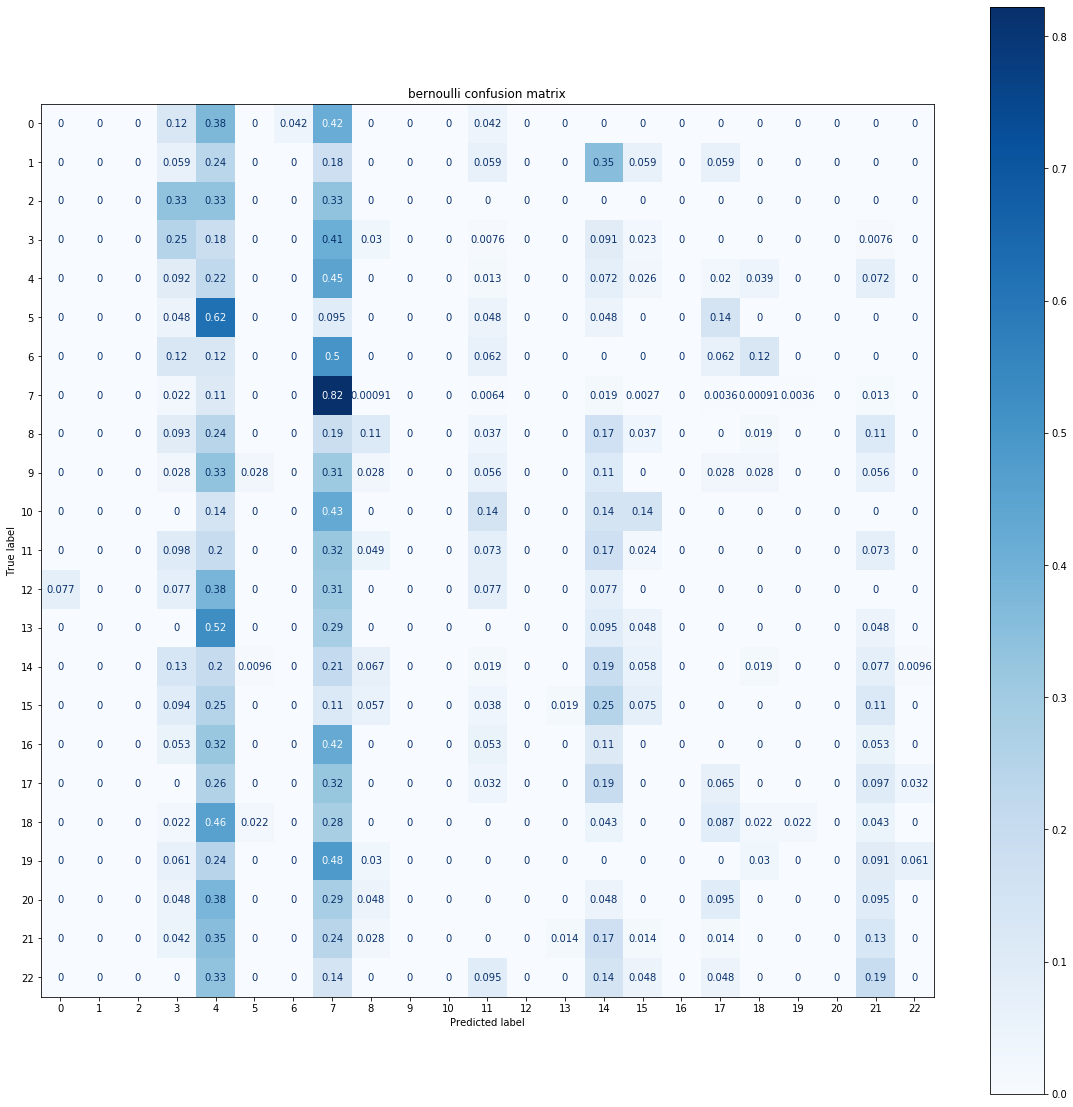

acc score -> bernoulli : 49.852507374631266 multinomial : 52.50737463126843


In [100]:
score_mlt, score_bernoulli = build_ml(
    train = x_all_train_df, 
    test = x_all_test_df, 
    train_y = np.array(y_all_train_df),
    test_y = np.array(y_all_test_df),
    vectorizer = base_vectorizer
)

In [101]:
games_df = pd.read_csv('dataset_binary_games.csv')
games_df = games_df.reset_index(drop=True).drop(['Unnamed: 0'], axis=1)
games_df

,id,track_name,price,cont_rating,prime_genre,vpp_lic,app_desc,is_games
0,302584613,"Kindle – Read eBooks, Magazines & Textbooks",0.00,4,book,1,turn kindle free kindle carry wherever go narr...,0
1,350480010,eBook: War and Peace,3.99,9,book,1,enjoy reading war peace day night multiple fon...,0
2,366869252,OverDrive – Library eBooks and Audiobooks,0.00,4,book,1,borrow streaming video library overdrive touch...,0
3,369111608,iBunkoHD,6.99,17,book,1,best way read comic realistic interface enjoy ...,0
4,379693831,"Audible – audio books, original series & podcasts",0.00,4,book,1,welcome audible company home unmatched selecti...,0
...,...,...,...,...,...,...,...,...
6235,924373886,Crossy Road - Endless Arcade Hopper,0.00,9,games,1,apple design award winner chicken cross pigeon...,1
6236,608899141,Cut the Rope: Time Travel,0.99,4,games,1,join om back time feed candy cut rope time tra...,1
6237,1070525362,Cosmic Challenge: Best online space racing game,0.00,4,games,1,space race competition space race different sp...,1
6238,1100810556,Hidden Expedition: Dawn of Prosperity - A Myst...,6.99,9,games,1,pay play forever unusual signal vicinity old a...,1


In [102]:
x_games_df = games_df.iloc[:, [2,3,5,6]]
y_games_df = games_df.iloc[:, [7]]

In [103]:
train_inds, test_inds = next(StratifiedShuffleSplit(
    test_size=.30, n_splits=1, random_state = 42
).split(x_games_df, y_games_df, groups=games_df['is_games']))

In [104]:
# train
x_all_train_df = x_games_df.iloc[train_inds]
y_all_train_df = y_games_df.iloc[train_inds]
# test
x_all_test_df = x_games_df.iloc[test_inds]
y_all_test_df = y_games_df.iloc[test_inds]

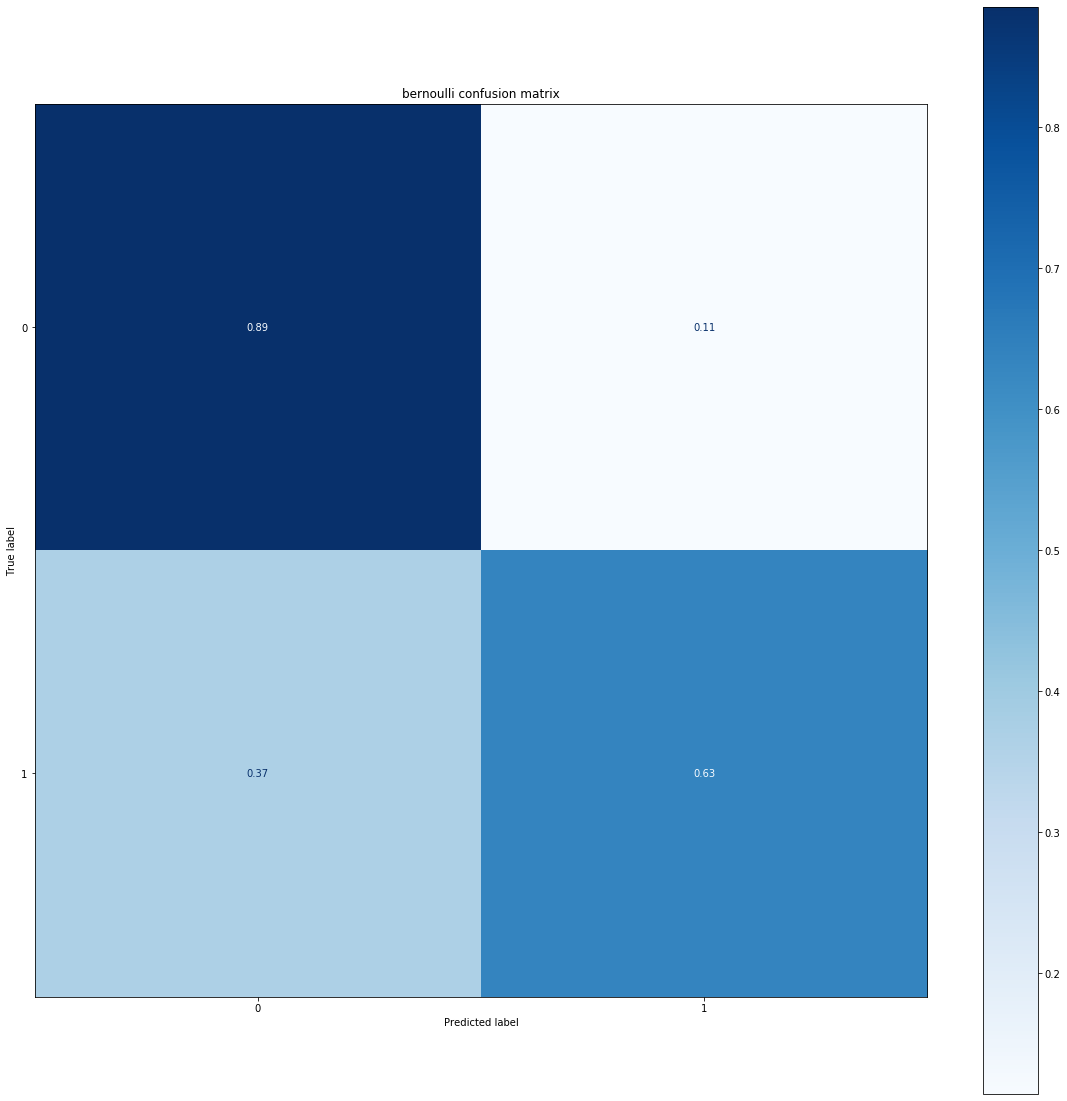

acc score -> bernoulli : 76.01495726495726 multinomial : 68.05555555555556


In [105]:
score_mlt, score_bernoulli = build_ml(
    train = x_all_train_df, 
    test = x_all_test_df, 
    train_y = np.array(y_all_train_df),
    test_y = np.array(y_all_test_df),
    vectorizer = base_vectorizer
)